0.35153765614145677, 0.017867877002622323, 0.04345427064541731, 0.07628419849862714, 0.18552153610183472, 0.09621165265182983, 0.032242972065326996, 0.41076109991665005


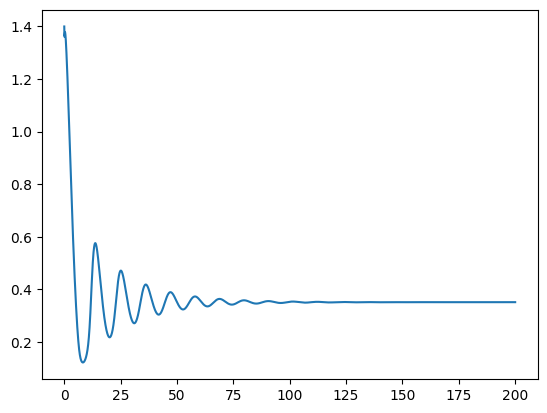

In [3]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

c1 = 0.185
c0 = 2
nu1 = 6
nu2 = 0.11
nu3 = 0.9
k3 = 0.1

a1 = 400
a2 = 0.2
a3 = 400
a4 = 0.2
a5 = 20

d1 = 0.13
d2 = 1.049
d3 = 943.4e-3
d4 = 144.5e-3
d5 = 82.34e-3

J1 = lambda C, CER, x110: c1 * (nu1 * x110 ** 3 + nu2) * (CER - C)
J2 = lambda C: nu3 * C**2 / (C**2 + k3**2)
CER = lambda C: (c0 - C) / c1
dCdt = lambda C, x110: J1(C, CER(C), x110) - J2(C)

def deyoungkeizerode(t, x, P):
    C, x000, x001, x010, x011, x100, x101, x110 = x
    x111 = 1 - x000 - x001 - x010 - x011 - x100 - x101 - x110

    # print(x000 + x001 + x010 + x011 + x100 + x101 + x110 + x111)

    # Bottom face
    V1 = a4 * (C * x000 - d4 * x001) # x000 to x001
    V2 = a4 * (C * x010 - d4 * x011) # x010 to x011
    V3 = a5 * (C * x000 - d5 * x010) # x000 to x010
    V4 = a5 * (C * x001 - d5 * x011) # x001 to x011

    # Sides
    V5 = a1 * (P * x000 - d1 * x100) # x000 to x100
    V6 = a1 * (P * x010 - d1 * x110) # x010 to x110
    V7 = a3 * (P * x001 - d3 * x101) # x001 to x101
    V8 = a3 * (P * x011 - d3 * x111) # x011 to x111

    # Top face
    V9 = a2 * (C * x100 - d2 * x101) # x100 to x101
    V10 = a2 * (C * x110 - d2 * x111) # x110 to x111
    V11 = a5 * (C * x100 - d5 * x110) # x100 to x110
    V12 = a5 * (C * x101 - d5 * x111) # x101 to x111

    dx000dt = -V1 - V3 - V5
    dx001dt = V1 - V4 - V7
    dx010dt = V3 - V2 - V6
    dx011dt = V2 + V4 - V8

    dx100dt = V5 - V9 - V11
    dx101dt = V7 + V9 - V12
    dx110dt = V6 - V10 + V11

    # print(dx000dt + dx001dt + dx010dt + dx011dt + dx100dt + dx101dt + dx110dt + dx111dt)
    # print(sum([x000, x001, x010, x011, x100, x101, x110, x111]))

    return [dCdt(C, x110), dx000dt, dx001dt, dx010dt, dx011dt, dx100dt, dx101dt, dx110dt]

P = 0.7
t_span = [0, 200]
y0 = [1.4, 1, 0, 0, 0, 0, 0, 0]
sol = solve_ivp(deyoungkeizerode, t_span, y0, args=(P,), max_step=0.1, rtol=1e-6, atol=1e-8)
plt.plot(sol.t, sol.y[0])
print(', '.join(list(map(str, sol.y[:, -1]))))

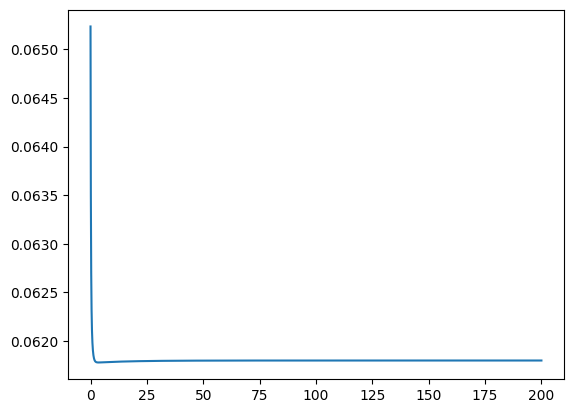

In [29]:
from scipy.optimize import fsolve

# def find_steady_state(P, initial_guess=None, unsteady=False):
#     if initial_guess is None:
#         initial_guess = [0.35153765614145677, 0.017867877002622323, 0.04345427064541731, 0.07628419849862714, 0.18552153610183472, 0.09621165265182983, 0.032242972065326996, 0.41076109991665005]
#
#     # func = lambda x: deyoungkeizerode(0, x, P)
#     # C, x000, x001, x010, x011, x100, x101, x110, x111 = fsolve(func, initial_guess)
#     # return C, x000, x001, x010, x011, x100, x101, x110, x111
#
#     eps = 1e-9
#     def steady_state_event(t, x, P):
#         return np.linalg.norm(deyoungkeizerode(t, x, P)) - eps
#
#     # Make it a terminal event
#     steady_state_event.terminal = True
#     # We want to trigger when the value crosses zero *downward* (norm(dxdt) < tol)
#     steady_state_event.direction = -1
#
#     t_span = [0, 500]
#     if not unsteady:
#         sol = solve_ivp(deyoungkeizerode, t_span, initial_guess, args=(P,), max_step=0.1, rtol=1e-6, atol=1e-8, events=steady_state_event)
#     else:
#         sol = solve_ivp(lambda t, x, P: np.negative(deyoungkeizerode(t, x, P)), t_span, initial_guess, args=(P,), max_step=0.1, rtol=1e-6, atol=1e-8, events=steady_state_event)
#
#     # for i in range(8):
#     #     plt.plot(sol.t, sol.y[i], label=f'{i}')
#
#     plt.plot(sol.t, sol.y[0], label=f'{P}')
#
#     return sol.y[:, -1]

def find_steady_state(P, initial_guess=None):
    if initial_guess is None:
        initial_guess = [0.35153765614145677, 0.017867877002622323, 0.04345427064541731, 0.07628419849862714, 0.18552153610183472, 0.09621165265182983, 0.032242972065326996, 0.41076109991665005]

    func = lambda x: deyoungkeizerode(0, x, P)
    state = fsolve(func, initial_guess)
    return state

eigvec = [0.34355413, -0.52045281, -0.17240741,  0.47713049,  0.2416683, -0.40034827, -0.01824965,  0.36702351]
solution = [0.06180045, 0.25477404, 0.10894608, 0.19122117, 0.08176968, 0.19598004, 0.01154823, 0.14709321]

y0 = solution + np.multiply(eigvec, 1e-2)
sol = solve_ivp(deyoungkeizerode, t_span, y0, args=(0.1,), max_step=0.1, rtol=1e-6, atol=1e-8)
plt.plot(sol.t, sol.y[0])
# print(sum([0.06186739406809979, 0.0337765780431877, 0.059291949202903746, 0.03237051082804615, 0.23795152096795955, 0.01790151402354118, 0.22804596357260917, 0.017156301410892524]))
# print(deyoungkeizerode(0, (0.07891231190364839, 0.06186739406809979, 0.0337765780431877, 0.059291949202903746, 0.03237051082804615, 0.23795152096795955, 0.01790151402354118, 0.22804596357260917, 0.017156301410892524), 0.5))

In [35]:
import sympy as sp

def jacobian(state, P):
    # print(state, P)
    C, x000, x001, x010, x011, x100, x101, x110, x111 = sp.symbols('C x000 x001 x010 x011 x100 x101 x110 x111')
    dCdt = c1 * (nu1 * x110 ** 3 + nu2) * ((c0 - C) / c1 - C)
    x111 = 1 - x000 - x001 - x010 - x011 - x100 - x101 - x110

    # Bottom face
    V1 = a4 * (C * x000 - d4 * x001) # x000 to x001
    V2 = a4 * (C * x010 - d4 * x011) # x010 to x011
    V3 = a5 * (C * x000 - d5 * x010) # x000 to x010
    V4 = a5 * (C * x001 - d5 * x011) # x001 to x011

    # Sides
    V5 = a1 * (P * x000 - d1 * x100) # x000 to x100
    V6 = a1 * (P * x010 - d1 * x110) # x010 to x110
    V7 = a3 * (P * x001 - d3 * x101) # x001 to x101
    V8 = a3 * (P * x011 - d3 * x111) # x011 to x111

    # Top face
    V9 = a2 * (C * x100 - d2 * x101) # x100 to x101
    V10 = a2 * (C * x110 - d2 * x111) # x110 to x111
    V11 = a5 * (C * x100 - d5 * x110) # x100 to x110
    V12 = a5 * (C * x101 - d5 * x111) # x101 to x111

    dx000dt = -V1 - V3 - V5
    dx001dt = V1 - V4 - V7
    dx010dt = V3 - V2 - V6
    dx011dt = V2 + V4 - V8

    dx100dt = V5 - V9 - V11
    dx101dt = V7 + V9 - V12
    dx110dt = V6 - V10 + V11

    F = sp.Matrix([dCdt, dx000dt, dx001dt, dx010dt, dx011dt, dx100dt, dx101dt, dx110dt])
    return np.array(F.jacobian([C, x000, x001, x010, x011, x100, x101, x110]).subs(list(zip([C, x000, x001, x010, x011, x100, x101, x110], state)))).astype(np.float64)

[[-1.52985966e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  7.50563255e-01]
 [-5.14685530e+00 -2.01248413e+02  2.89000000e-02  1.64680000e+00
   0.00000000e+00  5.20000000e+01  0.00000000e+00  0.00000000e+00]
 [-2.12821583e+00  1.23605201e-02 -2.01264952e+02  0.00000000e+00
   1.64680000e+00  0.00000000e+00  3.77360000e+02  0.00000000e+00]
 [ 5.05764766e+00  1.23605201e+00  0.00000000e+00 -2.01659161e+02
   2.89000000e-02  0.00000000e+00  0.00000000e+00  5.20000000e+01]
 [ 2.21742347e+00 -3.77360000e+02 -3.76123948e+02 -3.77347639e+02
  -5.79035700e+02 -3.77360000e+02 -3.77360000e+02 -3.77360000e+02]
 [-3.95911965e+00  2.00000000e+02  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -5.32484125e+01  2.09800000e-01  1.64680000e+00]
 [-1.91792374e-01 -1.64680000e+00  1.98353200e+02 -1.64680000e+00
  -1.64680000e+00 -1.63443948e+00 -3.80452652e+02 -1.64680000e+00]
 [ 3.89049838e+00 -2.09800000e-01 -2.09800000e-01  1.99790200e+02
  -

0
[-4.17552476e+02 -4.20435285e+02  6.48673335e-01 -3.44417330e-02
 -3.70860770e+00 -9.20123552e+01 -2.94139808e+00 -9.48951642e+01]
False
1
[-4.44209323e+02 -4.47330325e+02 -4.70026242e+00  1.35341681e+00
 -4.12483319e-02 -1.18681404e+02 -1.21802406e+02 -3.19179271e+00]
False
2
[-4.70867282e+02 -4.74377629e+02 -1.45351964e+02 -1.48862310e+02
 -5.59379947e+00  1.77900993e+00 -4.12442250e-02 -3.59373811e+00]
False
3
[-4.97526176e+02 -5.01635194e+02 -6.35591037e+00  1.83294154e+00
 -2.97555096e-02 -1.72024616e+02 -1.76133634e+02 -4.20617044e+00]
False
4
[-5.24185861e+02 -5.29104242e+02 -1.98699375e+02 -7.00313175e+00
  1.53926033e+00  3.42167998e-03 -2.03617755e+02 -5.03060950e+00]
False
5
[-7.59537210e+00  1.09421274e+00  7.35266141e-02 -5.50846222e+02
 -2.25374919e+02 -5.93364913e+00 -2.31181153e+02 -5.56652457e+02]
False
6
[-5.77507165e+02  5.78950915e-01  2.55863674e-01 -8.16449180e+00
 -5.84155573e+02 -2.52050006e+02 -2.58698413e+02 -6.78996808e+00]
False
7
[-6.04168613e+02+0.j     

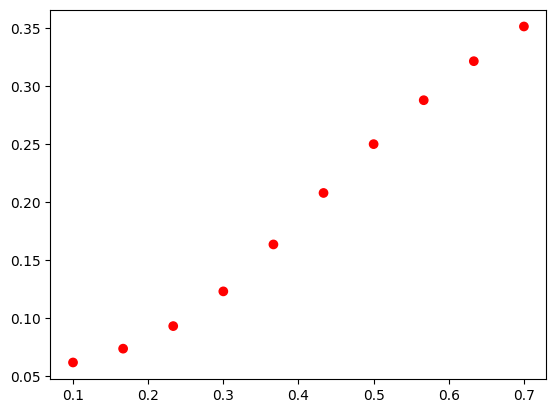

In [34]:
eps = 1e-10
n_points = 10
Ps = np.linspace(0.1, 0.7, n_points)
stabilities = np.zeros_like(Ps)
states = np.zeros((8, n_points))
for i, P in enumerate(Ps):
    print(i)
    if i == 0:
        guess = [0.35153765614145677, 0.017867877002622323, 0.04345427064541731, 0.07628419849862714, 0.18552153610183472, 0.09621165265182983, 0.032242972065326996, 0.41076109991665005]
    else:
        guess = states[:, i - 1]

    new_state = find_steady_state(P, guess)
    eigvals, eigvecs = np.linalg.eig(jacobian(new_state, P))
    print(eigvals)

    stable = max(eigvals) < eps
    print(stable)

    states[:, i] = new_state
    stabilities[i] = stable

colors = ['blue' if stable else 'red' for stable in stabilities]
plt.scatter(Ps, states[0], c=colors)
# plt.legend()